In [71]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

Thiết lập cấu hình

In [72]:
FILE_PATH = "/content/drive/MyDrive/Dữ liệu/BK_20_Test_3_clean.csv"
FUTURE_MONTHS = 60
POINT_MONTHS = [12, 24, 36, 48, 60]
USE_SMOOTHING = True
SAVGOL_WINDOW = 11
SAVGOL_POLY = 2
USE_OUTLIER_REMOVAL = True
IQR_MULTIPLIER = 1.5
MIN_POINTS_REQUIRED = 12
np.random.seed(42)

Hàm DCA

In [73]:
def exp_decline(t, qi, di):
    return qi * np.exp(-di * t)

def hyperbolic_decline(t, qi, di, b):
    return qi / ((1.0 + b * di * t) ** (1.0 / b))

def harmonic_decline(t, qi, di):
    return qi / (1.0 + di * t)

Công cụ hỗ trợ

In [74]:
def safe_savgol(x, window, poly):
    if len(x) < window:
        w = len(x) if len(x) % 2 == 1 else len(x)-1
        if w < 3: return x
        return savgol_filter(x, w, min(poly, w-1))
    return savgol_filter(x, window, poly)

In [75]:
def iqr_mask(series, multiplier=1.5):
    q1 = np.nanpercentile(series, 25)
    q3 = np.nanpercentile(series, 75)
    iqr = q3 - q1
    low = q1 - multiplier * iqr
    high = q3 + multiplier * iqr
    return (series >= low) & (series <= high)

Tải file

In [76]:
if not os.path.exists(FILE_PATH):
    raise FileNotFoundError(f"File not found: {FILE_PATH}\nIf using Colab mount drive: from google.colab import drive; drive.mount('/content/drive')")

df = pd.read_csv(FILE_PATH)

Thiết lập thời gian (theo tháng)

In [77]:
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df = df.sort_values('Date').reset_index(drop=True)
    df['t_days'] = (df['Date'] - df['Date'].iloc[0]).dt.days
    df['t_months'] = df['t_days'] / 30.0
    t_col = 't_months'
else:
    df = df.reset_index(drop=True)
    df['t_months'] = np.arange(len(df))
    t_col = 't_months'

In [78]:
if 'Water cut' not in df.columns:
    raise KeyError("Column 'Water cut' not found in dataset. DCA requires Qoil.")

In [79]:
# Oil Cut = 100 - Water Cut
df['Oil cut'] = 100 - df['Water cut']
# Loại bỏ giá trị âm hoặc > 100 nếu có (làm sạch)
df = df[(df['Oil cut'] >= 0) & (df['Oil cut'] <= 100)].reset_index(drop=True)

In [80]:
# Lấy dữ liệu fit: Dùng 'Oil cut' thay vì 'Water cut'
df_q = df[[t_col, 'Oil cut']].copy().dropna().reset_index(drop=True)
df_q.columns = ['t', 'Q_oil'] # Đổi tên thành Q_oil để khớp logic DCA

Xử lý nhiễu

In [81]:
mask = np.ones(len(df_q), dtype=bool)
if USE_OUTLIER_REMOVAL:
    mask = iqr_mask(df_q['Q_oil'].values, multiplier=IQR_MULTIPLIER)

t_all = df_q['t'].values
q_all = df_q['Q_oil'].values # Đây chính là Oil Cut thực tế

t_fit = t_all[mask]
q_fit = q_all[mask]

Làm mượt

In [82]:
# Làm trơn
q_fit_processed = q_fit.copy()
if USE_SMOOTHING:
    window = min(SAVGOL_WINDOW, len(q_fit_processed))
    if window % 2 == 0: window -= 1
    if window >= 3:
        q_fit_processed = safe_savgol(q_fit_processed, window, SAVGOL_POLY)

Fit models

In [83]:
results = {}

# Exponential
try:
    p0 = [np.max(q_fit_processed), 0.01]
    # Bounds: qi > 0, di > 0 (vì Oil Cut giảm)
    bounds = ([0, 0], [np.inf, 5.0])
    popt, pcov = curve_fit(exp_decline, t_fit, q_fit_processed, p0=p0, bounds=bounds, maxfev=10000)
    results['exp'] = {'params': popt}
except Exception as e:
    results['exp'] = {'error': str(e)}

In [84]:
# Hyperbolic
try:
    p0 = [np.max(q_fit_processed), 0.01, 0.5]
    bounds = ([0, 0, 0.01], [np.inf, 5.0, 2.0]) # b trong khoảng [0, 2]
    popt, pcov = curve_fit(hyperbolic_decline, t_fit, q_fit_processed, p0=p0, bounds=bounds, maxfev=10000)
    results['hyperbolic'] = {'params': popt}
except Exception as e:
    results['hyperbolic'] = {'error': str(e)}

In [85]:
# Harmonic
try:
    p0 = [np.max(q_fit_processed), 0.01]
    bounds = ([0, 0], [np.inf, 5.0])
    popt, pcov = curve_fit(harmonic_decline, t_fit, q_fit_processed, p0=p0, bounds=bounds, maxfev=10000)
    results['harmonic'] = {'params': popt}
except Exception as e:
    results['harmonic'] = {'error': str(e)}

Dự báo và tính toán Metrics

In [86]:
t_min = t_all.min()
t_max = t_all.max()
n_points = int(np.round((t_max - t_min))) + FUTURE_MONTHS + 1
t_forecast = np.linspace(t_min, t_max + FUTURE_MONTHS, n_points)
forecast_df = pd.DataFrame({'t': t_forecast})

In [87]:
metrics = {}
for key, info in results.items():
    if 'error' in info: continue

    if key == 'exp':
        qi, di = info['params']
        pred_in = exp_decline(t_all, qi, di)
        pred_out = exp_decline(t_forecast, qi, di)
    elif key == 'hyperbolic':
        qi, di, b = info['params']
        pred_in = hyperbolic_decline(t_all, qi, di, b)
        pred_out = hyperbolic_decline(t_forecast, qi, di, b)
    else:
        qi, di = info['params']
        pred_in = harmonic_decline(t_all, qi, di)
        pred_out = harmonic_decline(t_forecast, qi, di)

    forecast_df[key + '_pred'] = pred_out

    rmse = np.sqrt(mean_squared_error(q_all, pred_in))
    r2 = r2_score(q_all, pred_in)
    metrics[key] = {'rmse': rmse, 'r2': r2}

In [88]:
# ---------- Print metrics ----------
print(
"\n=== DCA FIT METRICS (in-sample) ===")
for key, val in metrics.items():
    if 'error' in val:
        print(f"{key}: ERROR - {val['error']}")
    else:
        print(f"{key.upper()} params: {results[key]['params']}")
        print(f"  RMSE: {val['rmse']:.4f} | R2: {val['r2']:.4f}")
    print("-" * 40)


=== DCA FIT METRICS (in-sample) ===
EXP params: [6.21388669e+01 1.48063783e-02]
  RMSE: 4.2489 | R2: 0.8478
----------------------------------------
HYPERBOLIC params: [6.96447462e+01 3.45461648e-02 1.69518143e+00]
  RMSE: 3.8408 | R2: 0.8757
----------------------------------------
HARMONIC params: [6.63692385e+01 2.37584386e-02]
  RMSE: 3.9179 | R2: 0.8706
----------------------------------------


In kết quả

In [89]:
# --- xuất file csv ---
csv_filename = "OilCut_Forecast_Result.csv"
forecast_df.to_csv(csv_filename, index=False)
print(f"Đã xuất kết quả dự báo ra file: {csv_filename}")

Đã xuất kết quả dự báo ra file: OilCut_Forecast_Result.csv


In biểu đồ kết quả

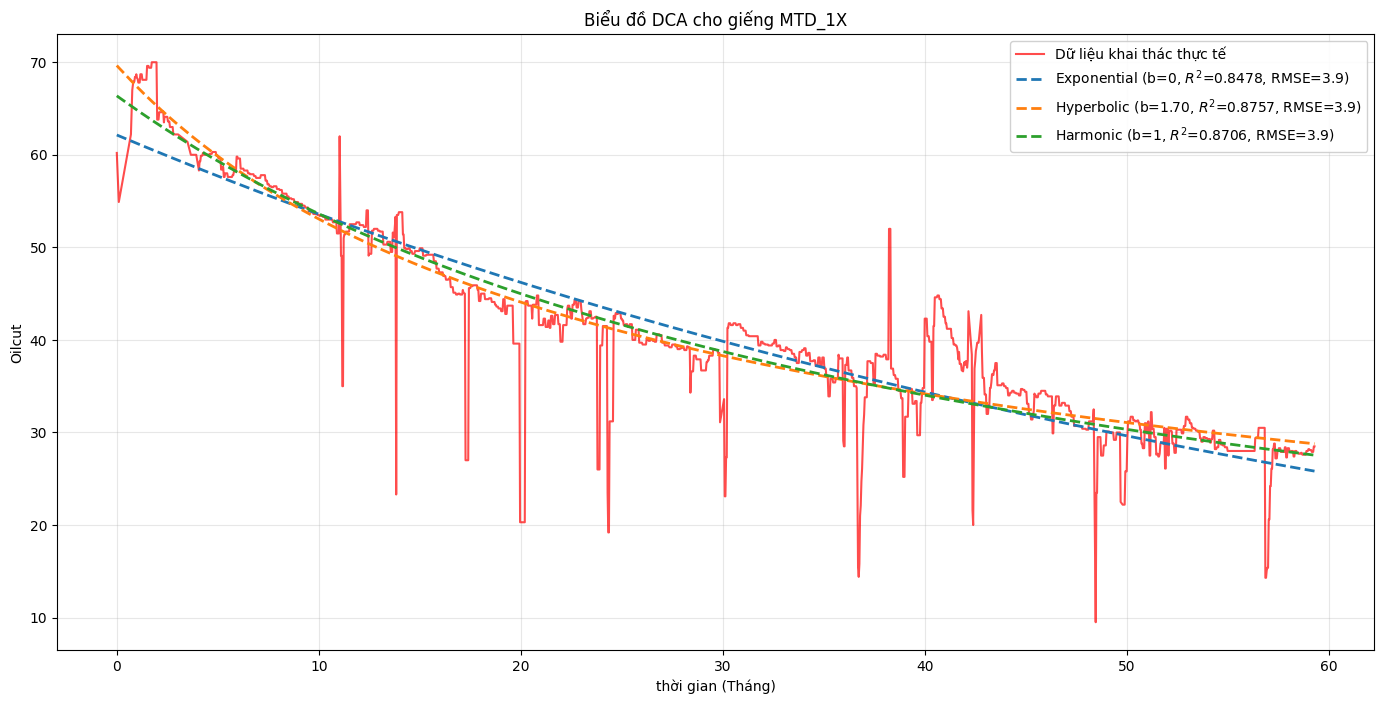

In [90]:
# ---------- Plot 1: Observed vs fits (in-sample) WITH METRICS ----------
plt.figure(figsize=(17, 8))
plt.plot(t_all, q_all, label='Dữ liệu khai thác thực tế', color='red', linewidth=1.5, alpha=0.7)

for key in ['exp', 'hyperbolic', 'harmonic']:
    if 'params' in results.get(key, {}) and key in metrics:
        r2 = metrics[key]['r2']
        mse = metrics[key]['rmse'] ** 2

        if key == 'exp':
            qi, di = results[key]['params']
            pred_in = exp_decline(t_all, qi, di)
            label_str = f"Exponential (b=0, $R^2$={r2:.4f}, RMSE={rmse:.1f})"

        elif key == 'hyperbolic':
            qi, di, b = results[key]['params']
            pred_in = hyperbolic_decline(t_all, qi, di, b)
            label_str = f"Hyperbolic (b={b:.2f}, $R^2$={r2:.4f}, RMSE={rmse:.1f})"

        else: # harmonic
            qi, di = results[key]['params']
            pred_in = harmonic_decline(t_all, qi, di)
            label_str = f"Harmonic (b=1, $R^2$={r2:.4f}, RMSE={rmse:.1f})"

        plt.plot(t_all, pred_in, label=label_str,linestyle='--', linewidth=2)

plt.title("Biểu đồ DCA cho giếng MTD_1X")
plt.xlabel("thời gian (Tháng)")
plt.ylabel("Oilcut")
plt.legend(loc='best', frameon=True, fancybox=True, framealpha=0.9)
plt.grid(alpha=0.3)
plt.show()

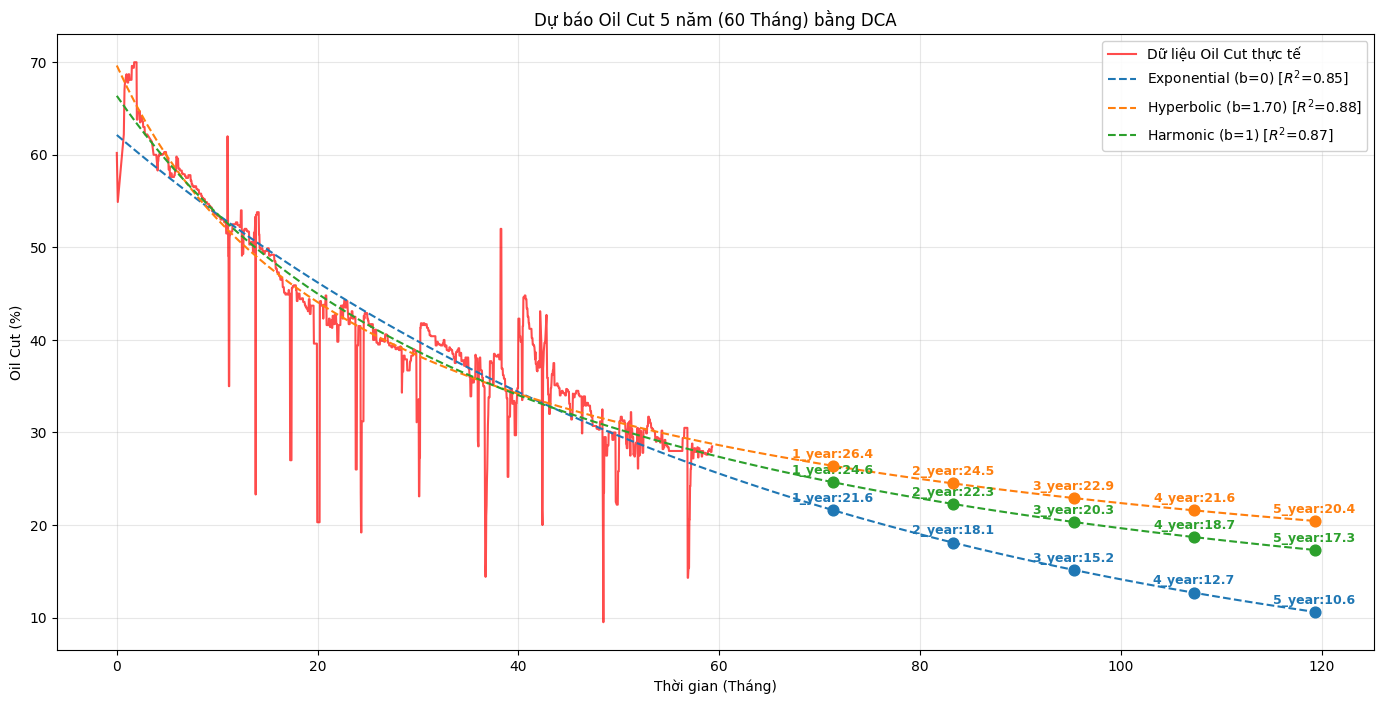

In [91]:
# ---------- Plot 2: Extended forecasts with Line Chart for Observed & Metrics Labels ----------
plt.figure(figsize=(17, 8))

# 1. Vẽ dữ liệu quan sát (Observed) dạng ĐƯỜNG (Dữ liệu Oil Cut)
plt.plot(t_all, q_all, color='red', linewidth=1.5, alpha=0.7, label='Dữ liệu Oil Cut thực tế')

# 2. Vẽ các đường dự báo
for key in ['exp','hyperbolic','harmonic']:
    col = key + '_pred'
    if col in forecast_df and not forecast_df[col].isna().all() and key in metrics:
        r2 = metrics[key]['r2']
        rmse = metrics[key]['rmse'] # Lấy rmse để hiển thị nếu cần

        if key == 'exp':
            label_str = f"Exponential (b=0)"
        elif key == 'hyperbolic':
            b = results[key]['params'][2]
            label_str = f"Hyperbolic (b={b:.2f})"
        else:
            label_str = f"Harmonic (b=1)"

        # Thêm thông tin R2 vào label cho rõ ràng (tuỳ chọn)
        label_str += f" [$R^2$={r2:.2f}]"

        plt.plot(forecast_df['t'], forecast_df[col], linestyle='--', label=label_str)
# 3. Đánh dấu và chú thích 5 điểm
colors = {'exp':'tab:blue','hyperbolic':'tab:orange','harmonic':'tab:green'}
for key in ['exp','hyperbolic','harmonic']:
    if 'params' not in results.get(key, {}):
        continue
    if key == 'exp':
        qi, di = results[key]['params']
        vals = exp_decline(np.array(year_points), qi, di)
    elif key == 'hyperbolic':
        qi, di, b = results[key]['params']
        vals = hyperbolic_decline(np.array(year_points), qi, di, b)
    else:
        qi, di = results[key]['params']
        vals = harmonic_decline(np.array(year_points), qi, di)

    plt.scatter(year_points, vals, marker='o', s=60, color=colors[key], edgecolor=colors[key], zorder=5)

    for m, t_abs, v in zip(POINT_MONTHS, year_points, vals):
        # Annotate: Hiển thị năm và giá trị Oil Cut
        plt.annotate(f"{int(m/12)}_year:{v:.1f}", (t_abs, v),
                     textcoords="offset points", xytext=(0,6), ha='center', fontsize=9, color=colors[key], fontweight='bold')

plt.title(f"Dự báo Oil Cut 5 năm (60 Tháng) bằng DCA")
plt.xlabel("Thời gian (Tháng)")
plt.ylabel("Oil Cut (%)") # Đổi nhãn trục Y
plt.legend(loc='best', frameon=True, fancybox=True, framealpha=0.9)
plt.grid(alpha=0.3)
plt.show()

In [92]:
# ==========================================
# 6. XUẤT FILE CSV DỰ BÁO 3 NĂM (KÈM NGÀY THÁNG)
# ==========================================

# 1. Xác định ngày bắt đầu và ngày kết thúc dữ liệu thực tế
start_date_real = df['Date'].min()
last_date_real = df['Date'].max()

# 2. Chuyển đổi cột 't' (tháng) trong bảng dự báo ngược lại thành 'Date'
# Công thức: Date = Ngày bắt đầu + (t_tháng * 30.44 ngày/tháng)
# 30.44 là trung bình số ngày trong tháng của một năm
forecast_df['Date'] = start_date_real + pd.to_timedelta(forecast_df['t'] * 30.44, unit='D')

# 3. Lọc lấy phần DỰ BÁO (Future) trong 3 năm (1095 ngày)
# Điều kiện: Ngày > Ngày cuối thực tế  VÀ  Ngày <= Ngày cuối thực tế + 1095 ngày
end_date_forecast = last_date_real + pd.Timedelta(days=1095)

future_df = forecast_df[
    (forecast_df['Date'] > last_date_real) &
    (forecast_df['Date'] <= end_date_forecast)
].copy()

# 4. Định dạng lại cột Date cho đẹp (YYYY-MM-DD)
future_df['Date'] = future_df['Date'].dt.strftime('%Y-%m-%d')

# 5. Chọn các cột cần thiết để xuất
# Chỉ lấy Date, t, và các cột dự báo (bỏ các cột rỗng nếu có)
output_cols = ['Date', 't']
for key in ['exp', 'hyperbolic', 'harmonic']:
    col_name = key + '_pred'
    if col_name in future_df.columns:
        output_cols.append(col_name)

final_csv_df = future_df[output_cols]

# 6. Lưu file
csv_filename_3y = "OilCut_Forecast_3Years_1095Days.csv"
final_csv_df.to_csv(csv_filename_3y, index=False)

print(f"\nĐã xuất file dự báo 3 năm: {csv_filename_3y}")
print(f"Dữ liệu từ ngày: {final_csv_df['Date'].iloc[0]} đến ngày: {final_csv_df['Date'].iloc[-1]}")
print(f"Tổng số điểm dự báo: {len(final_csv_df)}")


Đã xuất file dự báo 3 năm: OilCut_Forecast_3Years_1095Days.csv
Dữ liệu từ ngày: 2025-09-07 đến ngày: 2028-08-10
Tổng số điểm dự báo: 36
